# Customer churn prediction

#### Load Dependencies 

In [35]:
import os
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from keras.layers.normalization import BatchNormalization

from sklearn import preprocessing
from sklearn import tree

from livelossplot import PlotLossesKeras


from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

#### Load Data 

In [2]:
# churnData = pd.read_csv('churn_dataset_demo.csv')
churnData = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

## Encoding categorical data

#### select dtype == object columns 

In [3]:
print(churnData.dtypes)
# print(churnData.dtypes.eq(object))
obj_df = churnData.select_dtypes(include=['object']).copy()
obj_df.head(2)

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
0,7590-VHVEG,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,5575-GNVDE,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,1889.5,No


#### converting whitespaces and blanks to NaN 

In [4]:
obj_df = obj_df.replace(r'^\s+$', np.nan, regex=True)
obj_df.head(2)

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
0,7590-VHVEG,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,5575-GNVDE,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,1889.5,No


#### finding NaN values

In [5]:
# this step gives us all the rows with NaN column values
obj_df[obj_df.isnull().any(axis=1)]
# obj_df[obj_df.isna().any(axis=1)]

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
488,4472-LVYGI,Female,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),NaN,No
753,3115-CZMZD,Male,No,Yes,Yes,No,No,No,No,No,No,No,No,Two year,No,Mailed check,NaN,No
936,5709-LVOEQ,Female,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,NaN,No
1082,4367-NUYAO,Male,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,Two year,No,Mailed check,NaN,No
1340,1371-DWPAZ,Female,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),NaN,No
3331,7644-OMVMY,Male,Yes,Yes,Yes,No,No,No,No,No,No,No,No,Two year,No,Mailed check,NaN,No
3826,3213-VVOLG,Male,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,Two year,No,Mailed check,NaN,No
4380,2520-SGTTA,Female,Yes,Yes,Yes,No,No,No,No,No,No,No,No,Two year,No,Mailed check,NaN,No
5218,2923-ARZLG,Male,Yes,Yes,Yes,No,No,No,No,No,No,No,No,One year,Yes,Mailed check,NaN,No
6670,4075-WKNIU,Female,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,NaN,No


In [6]:
# obj_df.loc[488]

#### removing NaN value rows 

In [7]:
obj_df = obj_df.dropna(how='any')
obj_df[obj_df.isnull().any(axis=1)]

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn


#### update dtype of TotalCharges column from object to float 

the issue is, pandas doesn't recognize TotalCharges as floating object

In [8]:
obj_df["TotalCharges"] = pd.to_numeric(obj_df["TotalCharges"])

#### converting object dtype to category

In [9]:
# getting list of names for object dtype columns 
objColumns = list(obj_df.select_dtypes(include=['object']).columns)

# objColumns.remove('customerID')

for column in objColumns:
    obj_df[column] = obj_df[column].astype('category')

# drop customer ID column, since we dont need to one hot encode it
obj_df = obj_df.drop(columns=['customerID'])
print(obj_df.dtypes)

gender              category
Partner             category
Dependents          category
PhoneService        category
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessBilling    category
PaymentMethod       category
TotalCharges         float64
Churn               category
dtype: object


#### assign the encoded variable to a new column 

In [10]:
print("Original features: \n", list(obj_df.columns), "\n")
data_dummies = pd.get_dummies(obj_df)
print("Features after One-hot Encoding: \n", list(data_dummies.columns), "\n")

Original features: 
 ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn'] 

Features after One-hot Encoding: 
 ['TotalCharges', 'gender_Female', 'gender_Male', 'Partner_No', 'Partner_Yes', 'Dependents_No', 'Dependents_Yes', 'PhoneService_No', 'PhoneService_Yes', 'MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_Yes', 'StreamingTV_No', 'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_No', 'PaperlessBilling_Yes', 'PaymentMe

In [11]:
churnData = data_dummies.drop(columns=['Churn_No'])
churnData.head()

,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,...,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,29.85,1,0,0,1,1,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0
1,1889.50,0,1,1,0,1,0,0,1,1,...,0,1,0,1,0,0,0,0,1,0
2,108.15,0,1,1,0,1,0,0,1,1,...,1,0,0,0,1,0,0,0,1,1
3,1840.75,0,1,1,0,1,0,1,0,0,...,0,1,0,1,0,1,0,0,0,0
4,151.65,1,0,1,0,1,0,0,1,1,...,1,0,0,0,1,0,0,1,0,1


In [12]:
# Get All Column's name of the input file
columnHeaders = list(churnData.columns.values)

# featureColumns = list(churnData.columns)
# featureColumns = featureColumns.remove('Churn_Yes')
# print(featureColumns)

#'quality' is the class attribute we are predicting
classColumn = 'Churn_Yes'
churnFeature = churnData.drop(columns=['Churn_Yes'])
churnClass = churnData[classColumn]

#### Splitting data into train and test 

In [13]:
# Splitting given dataset - Train: 75%, Test: 25%
trainFeature, testFeature, trainClass, testClass = train_test_split(churnFeature, churnClass, stratify=churnClass, train_size=.75, test_size=.25)
trainAccuracy = []
testAcuracy = []

### Decision Tree Classifier 

In [14]:
#clf = GaussianNB()
tree = DecisionTreeClassifier(random_state=0)
#tree.np(trainFeature, trainClass)
tree.fit(trainFeature, trainClass)
# tree.fit(trainFeature,trainClass)      

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [15]:
# Printing test and train accuracy of the classifier
print("Train set accuracy: {:.2f}".format(tree.score(trainFeature, trainClass)))
print("Test set accuracy: {:.2f}".format(tree.score(testFeature, testClass)))

Train set accuracy: 1.00
Test set accuracy: 0.73


#### Confusion matrix 

In [16]:
# Confusion matrix(6x6) including 'All' for test data
prediction = tree.predict(testFeature)
print("Confusion matrix:")
print(pd.crosstab(testClass, prediction, rownames=['True'], colnames=['Predicted'], margins=True))

Confusion matrix:
Predicted     0    1   All
True                      
0          1057  234  1291
1           240  227   467
All        1297  461  1758


#### Cross-Validation 

In [17]:
# Application of 10-fold stratified cross-validation
crossValidationScore = cross_val_score(tree, trainFeature, trainClass, cv=10)
print("Cross-validation scores: {}".format(crossValidationScore))
print("Average cross-validation score: {:.2f}".format(crossValidationScore.mean()))

Cross-validation scores: [0.70888469 0.72400756 0.72485769 0.75521822 0.74573055 0.74952562
 0.72675522 0.73814042 0.73244782 0.72675522]
Average cross-validation score: 0.73


In [18]:
# Pre-processing of Dataset
churnFeatureFinal = preprocessing.maxabs_scale(trainFeature)
churnFeatureFinal2 = MaxAbsScaler().fit_transform(churnFeatureFinal)

cvScoreFinal = cross_val_score(tree, churnFeatureFinal, trainClass, cv=10)
print("Post Pre-Processing Cross-validation scores: {}".format(cvScoreFinal))
print("Post Pre-Processing Average cross-validation score: {:.2f}".format(cvScoreFinal.mean()))

Post Pre-Processing Cross-validation scores: [0.70888469 0.72400756 0.72296015 0.75521822 0.74573055 0.74952562
 0.72675522 0.73814042 0.73244782 0.72675522]
Post Pre-Processing Average cross-validation score: 0.73


### Random forest classifier 

In [19]:
forest = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=0, n_jobs=4)
forest.fit(trainFeature, trainClass)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [20]:
# Printing test and train accuracy of the classifier
print("Train set accuracy: {:.2f}".format(forest.score(trainFeature, trainClass)))
print("Test set accuracy: {:.2f}".format(forest.score(testFeature, testClass)))

Train set accuracy: 0.87
Test set accuracy: 0.80


#### Confusion matrix 

In [21]:
# Confusion matrix(6x6) including 'All' for test data
prediction = forest.predict(testFeature)
print("Confusion matrix:")
print(pd.crosstab(testClass, prediction, rownames=['True'], colnames=['Predicted'], margins=True))

Confusion matrix:
Predicted     0    1   All
True                      
0          1169  122  1291
1           233  234   467
All        1402  356  1758


#### Cross-Validation 

In [22]:
# Application of 10-fold stratified cross-validation
crossValidationScore = cross_val_score(forest, trainFeature, trainClass, cv=10)
print("Cross-validation scores: {}".format(crossValidationScore))
print("Average cross-validation score: {:.2f}".format(crossValidationScore.mean()))

Cross-validation scores: [0.79773157 0.80151229 0.79506641 0.79696395 0.79696395 0.78557875
 0.78178368 0.80455408 0.77419355 0.81024668]
Average cross-validation score: 0.79


In [23]:
# Pre-processing of Dataset
churnFeatureFinal = preprocessing.maxabs_scale(trainFeature)
churnFeatureFinal2 = MaxAbsScaler().fit_transform(churnFeatureFinal)

cvScoreFinal = cross_val_score(forest, churnFeatureFinal, trainClass, cv=10)
print("Post Pre-Processing Cross-validation scores: {}".format(cvScoreFinal))
print("Post Pre-Processing Average cross-validation score: {:.2f}".format(cvScoreFinal.mean()))

Post Pre-Processing Cross-validation scores: [0.79773157 0.80151229 0.79506641 0.79696395 0.79696395 0.78557875
 0.78178368 0.80455408 0.77419355 0.81024668]
Post Pre-Processing Average cross-validation score: 0.79


#### ROC - AUC 

### Neural Net Classifier 

#### Design Neural Network Architecture 

In [49]:
# create model
model = Sequential()
model.add(Dense(54, input_dim=36, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 54)                1998      
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 440       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 9         
Total params: 2,447
Trainable params: 2,447
Non-trainable params: 0
_________________________________________________________________


#### Configure model  

In [51]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Train 

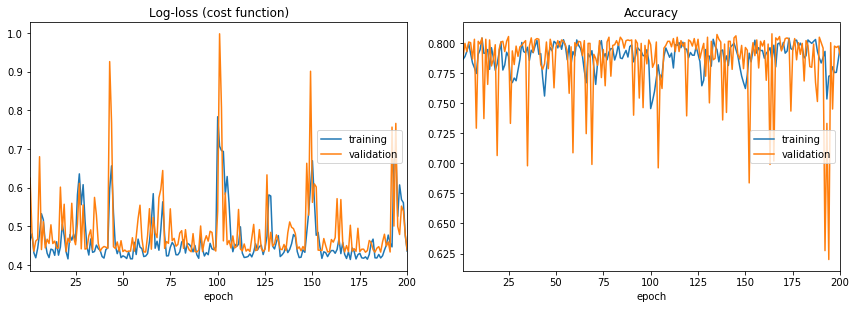

In [56]:
# trainFeature.head()

model.fit(trainFeature, trainClass,
          batch_size=512,epochs=200,verbose=0,
          validation_data=(testFeature,testClass), 
          callbacks=[PlotLossesKeras()])

#### Evaluate model 

In [57]:
# evaluate the model
scores = model.evaluate(trainFeature, trainClass)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

5274/5274 [==============================] - 1s 113us/step

acc: 79.94%
